In [17]:
import os
import cv2
from sklearn.cluster import KMeans
import time
import numpy as np
import copy
from sklearn.preprocessing import normalize
import math
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from gensim.models import LdaModel

In [2]:
# ----------------FUNCTIONS-------------------- #

# to overlay descriptors on image (colored by topic)
def prediction(model, img, img_bow, kp, kp_colors=None, show=True):
    img_copy=img.copy()
    for i in range(len(kp)):
        color = (255,0,0) if kp_colors is None else kp_colors[i]
        img = cv2.drawKeypoints(img, [kp[i]], 
                                img_copy, color=(color),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    if show:
        plt.imshow(img_copy)
        plt.show()
    else:
        return img_copy

# return index for a certain image name
def img_name2index(name, file_names):
    for i in range(len(file_names)):
        if name in file_names[i]:
            return i
    print("Not found..")
    return None
 
# initial utility to show overlayed keypoints on img, no topic coloring
def viewImgsWithKp(img, kp):
    print_img = copy.deepcopy(img)
    cv2.drawKeypoints(print_img,kp,print_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(print_img)

# get descriptors for an image using MSER, ORB keypoint generation
def siftImg(img):
    sift = cv2.xfeatures2d.SIFT_create()
    #0 - get grayscale
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #1 − Detect diff sources, describe with SIFT
    orb = cv2.ORB_create()
    mser = cv2.MSER_create()
    kp = mser.detect(grayImg)
    kp += orb.detect(grayImg)
    kp,des=sift.compute(grayImg, kp)
    return kp, des

# apply siftImg to multiple images
def siftImgs(imgs):
    imgs_kp = []
    imgs_des = []
    for img in imgs:
        sift_kp, sift_des = siftImg(img)
        imgs_des.append(sift_des)
        imgs_kp.append(sift_kp)
    return imgs_des, imgs_kp

# construct bow for a certain image given a clustering result
def get_bow(img_des, kmeans_res, verbose=False):
    img_bow_temp = np.zeros(kmeans_res.n_clusters)
    img_des_idx = kmeans_res.predict(np.array(img_des,dtype='double'))
    for idx in img_des_idx:
        img_bow_temp[idx] += 1
    img_bow = []
    for idx, freq in enumerate(img_bow_temp):
        if freq != 0:
            img_bow.append(tuple((idx,freq)))
    if verbose: print(img_bow)
    return img_bow

# create dictionary with descriptor as key and its index in original list as value
def create_des2idx_dict(des):
    des_dict = {}
    for i,descriptor in enumerate(des):
        des_dict[descriptor.tobytes()] = i
    return des_dict

# get index for a particular descriptor
def des2idx(descriptor,des_dict):
    return des_dict.get(descriptor.tobytes(), None) # None means descriptor not in training descriptors

# given an lda model, get the most probable topic for a descriptor
def des2topic(descriptor,kmeans_res,word2topic=None,model=None):
    keyword_idx = kmeans_res.predict(np.array(descriptor.reshape(1,-1),dtype='double'))[0]
    if word2topic is not None: 
        topic_des = word2topic[keyword_idx]
    else:
        topic_des = np.argsort([el[1] for el in model.get_term_topics(keyword_idx, minimum_probability=0)])[-1]  
    return topic_des

# create structure which for each descriptor gives its most probable topic
def get_word2topic(model, word_ids):
    word2topic = {}
    model_word_to_topic = model.get_topics()
    for i in word_ids:
        word2topic[i] = np.argsort(model_word_to_topic[:,i])[-1]
    return word2topic

# -------------------------------------------- #

In [3]:
colors = {
    0:(249,112,42), # orangey red
    1:(18,159,244), # cyan
    2:(248,73,242), # magenta
    3:(217,0,95),   # dark red
    4:(196,196,240),# light blue-grey
    5:(95,241,183), # water green
    6:(57,43,133),  # dark blue
    7:(136,20,116), # almost violet
    8:(157,218,45), # green pastel
    9:(130,91,24),  # brown
    10:(251,53,18), # highlighter red
    11:(150,47,225),# purple
    12:(0,0,0),     # black
    13:(255,255,150)# whiteish yellow
}

# PREPARING FOR VOCABULARY CREATION

In [4]:
# compute all SIFT descriptors
imgs_des = []
imgs = []
file_names = []
imgs_kp = []
img_folder = os.getcwd()+"\images\\"

for file_name in os.listdir(img_folder):
    if "GT" not in file_name:
        imgs.append(cv2.imread(img_folder+file_name))
        file_names.append(file_name)
        
# split into train and test
test_size = len(imgs)//5
order_mix = np.random.permutation(len(imgs))
file_names = np.array(file_names)[order_mix]
imgs = np.array(imgs)[order_mix]

train_imgs = imgs[:len(imgs) - test_size]
train_file_names = file_names[:len(file_names) - test_size]
test_imgs = imgs[len(imgs) - test_size:]
test_file_names = file_names[len(imgs) - test_size:]
print(f"Train size: {len(train_imgs)} - Test size: {len(test_imgs)}")

# get descriptor for all training imgs
start = time.time()
imgs_des, imgs_kp = siftImgs(train_imgs)
des = [ image_descriptor for image_descriptors in imgs_des for image_descriptor in image_descriptors ]
des_dict = create_des2idx_dict(des)
print(f"{len(des)} SIFT descriptors of {len(train_imgs)} images computed in {round(time.time()-start,3)} seconds")

Train size: 192 - Test size: 47
117244 SIFT descriptors of 192 images computed in 36.18 seconds


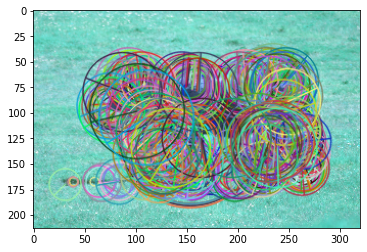

In [5]:
# quick test
file_to_search = '6'
viewImgsWithKp(train_imgs[img_name2index(file_to_search,train_file_names)],imgs_kp[img_name2index(file_to_search,train_file_names)])

# VOCABULARY CREATION ( DEFINE BOW ) 

In [6]:
# compute KMEANS
start = time.time()
ndim = 500
kmeans_res = KMeans(n_clusters=ndim, verbose=1, n_jobs=-2).fit(des)
print(kmeans_res.labels_)
print(f"KMeans with {ndim} clusters computed in {round(time.time()-start,3)} seconds")

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 8336355440.0
Iteration 1, inertia 6454477958.240936
Iteration 2, inertia 6308677397.025785
Iteration 3, inertia 6250418707.074844
Iteration 4, inertia 6216529911.528805
Iteration 5, inertia 6193509413.378395
Iteration 6, inertia 6176981601.093289
Iteration 7, inertia 6164499618.089401
Iteration 8, inertia 6155108215.561757
Iteration 9, inertia 6147553442.40737
Iteration 10, inertia 6141515645.267256
Iteration 11, inertia 6136466922.538092
Iteration 12, inertia 6132099883.858067
Iteration 13, inertia 6128380794.954906
Iteration 14, inertia 6125078101.49752
Iteration 15, inertia 6122308644.926702
Iteration 16, inertia 6119691340.183363
Iteration 17, inertia 6117448218.6033
Iteration 18, inertia 6115488013.413935
Iteration 19, inertia 6113674411.389469
Iteration 20, inertia 6111952228.364011
Iteration 21, inertia 6110237874.992793
Iteration 22, inertia 6108627607.663193
Iteration 23, inertia 6107239230.838324
Iteration 24, inertia 6105876629.84

Iteration 34, inertia 6099447544.194308
Iteration 35, inertia 6098893306.948508
Iteration 36, inertia 6098421052.42979
Iteration 37, inertia 6097960621.667886
Iteration 38, inertia 6097554017.820624
Iteration 39, inertia 6097202780.784855
Iteration 40, inertia 6096907829.454806
Iteration 41, inertia 6096605299.738223
Iteration 42, inertia 6096336205.595721
Iteration 43, inertia 6096001742.723782
Iteration 44, inertia 6095676769.87602
Iteration 45, inertia 6095326648.762202
Iteration 46, inertia 6095015562.561178
Iteration 47, inertia 6094750426.104004
Iteration 48, inertia 6094510163.813861
Iteration 49, inertia 6094205221.846477
Iteration 50, inertia 6093882323.241877
Iteration 51, inertia 6093572590.697006
Iteration 52, inertia 6093342529.868346
Iteration 53, inertia 6093104615.484746
Iteration 54, inertia 6092902182.04724
Iteration 55, inertia 6092733225.32417
Iteration 56, inertia 6092511585.474686
Iteration 57, inertia 6092275756.534412
Iteration 58, inertia 6092088161.380449
Iter

Iteration 105, inertia 6091905587.519272
Iteration 106, inertia 6091869006.42413
Iteration 107, inertia 6091826256.140926
Iteration 108, inertia 6091788328.544205
Iteration 109, inertia 6091753216.393294
Iteration 110, inertia 6091728216.048595
Iteration 111, inertia 6091710845.969728
Iteration 112, inertia 6091697528.1481
Iteration 113, inertia 6091683325.784646
Iteration 114, inertia 6091669620.54781
Iteration 115, inertia 6091660229.677164
Iteration 116, inertia 6091649472.707941
Iteration 117, inertia 6091641753.48272
Iteration 118, inertia 6091633101.822232
Iteration 119, inertia 6091626006.794582
Iteration 120, inertia 6091620109.970669
Iteration 121, inertia 6091615088.723164
Iteration 122, inertia 6091610166.646214
Iteration 123, inertia 6091603707.430847
Iteration 124, inertia 6091588412.947568
Iteration 125, inertia 6091577194.952284
Iteration 126, inertia 6091567257.314922
Iteration 127, inertia 6091556997.849003
Iteration 128, inertia 6091549663.583121
Iteration 129, inerti

Iteration 18, inertia 6112584525.652412
Iteration 19, inertia 6110245439.026526
Iteration 20, inertia 6108160957.758239
Iteration 21, inertia 6106300008.423815
Iteration 22, inertia 6104660666.950559
Iteration 23, inertia 6103021094.370698
Iteration 24, inertia 6101412369.027114
Iteration 25, inertia 6100230422.077849
Iteration 26, inertia 6099254321.25865
Iteration 27, inertia 6098455198.58349
Iteration 28, inertia 6097776311.966354
Iteration 29, inertia 6097133309.110424
Iteration 30, inertia 6096575831.417675
Iteration 31, inertia 6095987468.872244
Iteration 32, inertia 6095303871.309559
Iteration 33, inertia 6094713601.896391
Iteration 34, inertia 6094157740.92768
Iteration 35, inertia 6093710811.422496
Iteration 36, inertia 6093403583.374251
Iteration 37, inertia 6093118910.17443
Iteration 38, inertia 6092815519.972698
Iteration 39, inertia 6092529276.766275
Iteration 40, inertia 6092236536.008991
Iteration 41, inertia 6091917459.081136
Iteration 42, inertia 6091626696.44322
Itera

Iteration 128, inertia 6083858807.835583
Iteration 129, inertia 6083843749.021104
Iteration 130, inertia 6083834799.773907
Iteration 131, inertia 6083825370.942057
Iteration 132, inertia 6083811584.911695
Iteration 133, inertia 6083803447.850267
Iteration 134, inertia 6083791967.064967
Iteration 135, inertia 6083779615.509737
Iteration 136, inertia 6083770707.34814
Iteration 137, inertia 6083764091.365545
Iteration 138, inertia 6083757072.961528
Iteration 139, inertia 6083752826.8790045
Iteration 140, inertia 6083746512.015711
Iteration 141, inertia 6083741141.056467
Iteration 142, inertia 6083735077.88217
Iteration 143, inertia 6083728587.6549635
Iteration 144, inertia 6083724002.403422
Iteration 145, inertia 6083721422.302734
Iteration 146, inertia 6083718934.915748
Iteration 147, inertia 6083713517.420557
Iteration 148, inertia 6083710638.464063
Iteration 149, inertia 6083709491.202932
Iteration 150, inertia 6083708107.845366
Converged at iteration 150: strict convergence.
Initializ

Iteration 26, inertia 6101282419.887232
Iteration 27, inertia 6100205221.174703
Iteration 28, inertia 6099162103.346067
Iteration 29, inertia 6098198533.95812
Iteration 30, inertia 6097147500.938129
Iteration 31, inertia 6096292256.830893
Iteration 32, inertia 6095550665.375965
Iteration 33, inertia 6094888294.690674
Iteration 34, inertia 6094276706.946222
Iteration 35, inertia 6093642993.675079
Iteration 36, inertia 6093124340.652607
Iteration 37, inertia 6092659081.020208
Iteration 38, inertia 6092156770.489475
Iteration 39, inertia 6091592069.997225
Iteration 40, inertia 6091082284.46388
Iteration 41, inertia 6090620743.450108
Iteration 42, inertia 6090186319.698557
Iteration 43, inertia 6089814967.333008
Iteration 44, inertia 6089456532.276582
Iteration 45, inertia 6089057327.557412
Iteration 46, inertia 6088667305.491408
Iteration 47, inertia 6088370400.125146
Iteration 48, inertia 6088063961.252162
Iteration 49, inertia 6087792654.475478
Iteration 50, inertia 6087522504.716484
It

Iteration 93, inertia 6081396748.396908
Iteration 94, inertia 6081365310.15675
Iteration 95, inertia 6081334982.308961
Iteration 96, inertia 6081310113.231969
Iteration 97, inertia 6081279367.568209
Iteration 98, inertia 6081248706.156125
Iteration 99, inertia 6081223709.208336
Iteration 100, inertia 6081200873.669686
Iteration 101, inertia 6081179070.156854
Iteration 102, inertia 6081155458.276531
Iteration 103, inertia 6081139047.778886
Iteration 104, inertia 6081125681.834866
Iteration 105, inertia 6081114858.831971
Iteration 106, inertia 6081102409.278463
Iteration 107, inertia 6081075426.813905
Iteration 108, inertia 6081059793.006956
Iteration 109, inertia 6081045193.825585
Iteration 110, inertia 6081033921.316526
Iteration 111, inertia 6081023973.51702
Iteration 112, inertia 6081010951.053979
Iteration 113, inertia 6080994940.597585
Iteration 114, inertia 6080977302.864412
Iteration 115, inertia 6080954506.893662
Iteration 116, inertia 6080931451.303354
Iteration 117, inertia 60

In [7]:
# create bow as tuple of WORD - FREQ for every img
def get_bow(img_des, kmeans_res, verbose=False):
    img_bow_temp = np.zeros(kmeans_res.n_clusters)
    img_des_idx = kmeans_res.predict(np.array(img_des,dtype='double'))
    for idx in img_des_idx:
        img_bow_temp[idx] += 1
    img_bow = [] # process, we need a tuple!
    for idx, freq in enumerate(img_bow_temp):
        if freq != 0:
            img_bow.append(tuple((idx,freq)))
    if verbose: print(img_bow)
    return img_bow
bow = np.array([get_bow(img_des,kmeans_res) for img_des in imgs_des])

# create hyperdumb dict (needed to score coherence)
id2word = {}
for i in range(kmeans_res.n_clusters):
    id2word[i] = i

#  CHOOSING LDA MODEL

In [8]:
from gensim.models.coherencemodel import CoherenceModel
ntopic = 8 # minimum since there are at least 8 different types of images
n_topics =[i for i in range(ntopic, ntopic*3)]
model_grid_ntopics = []
for n in n_topics:
    lda = LdaModel(bow, num_topics=n, id2word=id2word, per_word_topics=True ,minimum_probability=0, random_state=123)
    model_grid_ntopics.append((n,CoherenceModel(model=lda, corpus=bow, coherence='u_mass').get_coherence()))

Best n_topics: 9 - Coherence: -0.8602037034887162


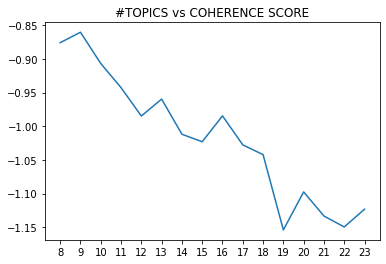

In [9]:
coherence_scores = [m[1] for m in model_grid_ntopics]
plt.xticks(range(len(n_topics)),n_topics)
plt.title("#TOPICS vs COHERENCE SCORE")
plt.plot(coherence_scores)
ntopic = n_topics[np.argsort(coherence_scores)[-1]]
print("Best n_topics:",ntopic, "- Coherence:",coherence_scores[np.argsort(coherence_scores)[-1]])

# BUILD MODEL

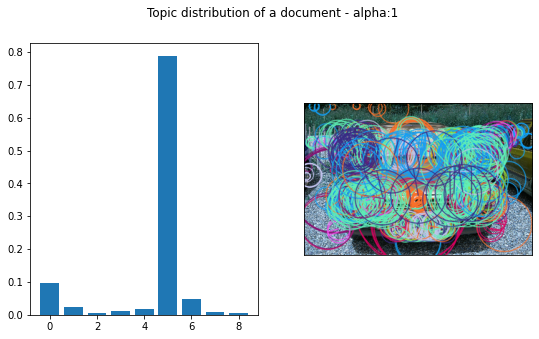

In [10]:
# create lda model (GENSIM for the win!)
chosen_alpha = 1
lda = LdaModel(bow, num_topics=ntopic, 
               alpha=chosen_alpha, 
               id2word=id2word, 
               per_word_topics=True, 
               minimum_probability=0, 
               random_state=123)

idx = 0
fig,axs = plt.subplots(1,2,figsize=(9,5))
fig.suptitle(f"Topic distribution of a document - alpha:{chosen_alpha}")
axs[0].bar([el[0] for el in lda.get_document_topics(bow[idx])],height=[el[1] for el in lda.get_document_topics(bow[idx])])
kp_colors = [colors[des2topic(imgs_des[idx][i], kmeans_res, model=lda)] for i in range(len(imgs_des[idx]))]
axs[1].imshow(prediction(lda, train_imgs[idx], bow[idx],imgs_kp[idx],kp_colors=kp_colors, show=False))
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

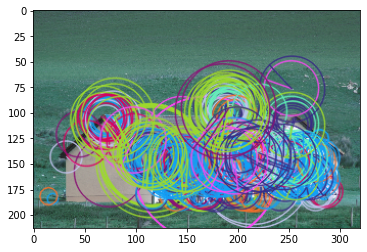

In [11]:
# time to test: get bow description for test imgs and a dictionary to get top topic per descriptor
test_imgs_des, test_imgs_kp = siftImgs(test_imgs)
test_bow = np.array([get_bow(img_des,kmeans_res) for img_des in test_imgs_des])
word2topic = get_word2topic(lda,[i for i in range(kmeans_res.n_clusters)])

# quick test
kp_colors = [colors[des2topic(test_imgs_des[idx][i], kmeans_res, model=lda)] for i in range(len(test_imgs_des[idx]))]
prediction(lda, test_imgs[idx], test_bow[idx],test_imgs_kp[idx],kp_colors=kp_colors)

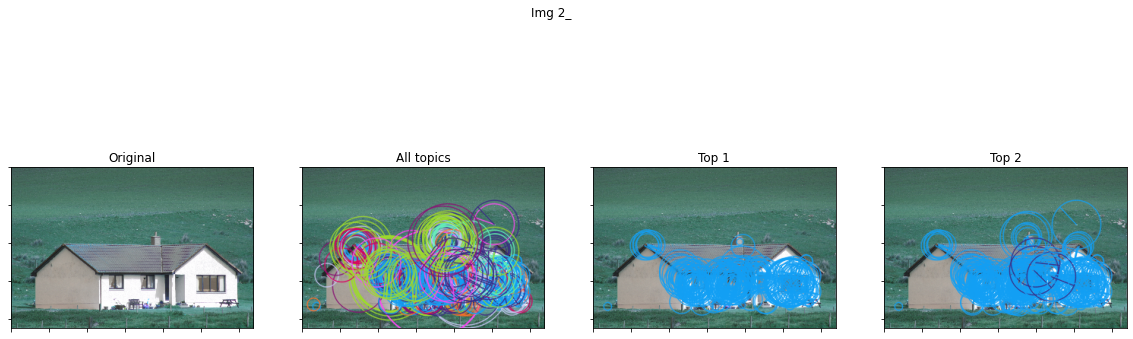

'3_12_s.bmp'

In [12]:
# get overlay on chosen img
# original | all topics overlay | most probable topic overlay | 2 most probable topics overlay

img_file_name = '2_'
idx = img_name2index( img_file_name , test_file_names)

fig,axs=plt.subplots(1,4, figsize=(20,20))
fig.suptitle(f"Img {img_file_name}")
axs[0].title.set_text("Original")
axs[0].imshow(test_imgs[idx])

lda_doc_top = lda.get_document_topics(test_bow[idx])

# get most relevant kp
top_topic = np.argsort(np.array([el[1] for el in lda_doc_top]))[-1]
top_topic_kp = []
kp_colors = []
for i in range(len(test_imgs_des[idx])):
    kp_topic = des2topic(test_imgs_des[idx][i],kmeans_res,model=lda)
    if kp_topic == top_topic:
        top_topic_kp.append(test_imgs_kp[idx][i])
        kp_colors.append(colors[top_topic])
top_topic_kp = np.array(top_topic_kp)
# print("Top topic:",top_topic)

axs[1].title.set_text("All topics")
axs[1].imshow(prediction(lda, test_imgs[idx], test_bow[idx],test_imgs_kp[idx], kp_colors=[colors[des2topic(test_imgs_des[idx][i], kmeans_res, model=lda)] for i in range(len(test_imgs_des[idx]))], show=False))


axs[2].title.set_text("Top 1")
axs[2].imshow(prediction(lda, test_imgs[idx], test_bow[idx],top_topic_kp,kp_colors, show=False))

lda_doc_top = lda.get_document_topics(test_bow[idx])
document_top_topics = np.argsort(np.array([el[1] for el in lda.get_document_topics(test_bow[idx])]))[-2:]
top_topic_kp = []
for i in range(len(test_imgs_des[idx])):
    kp_topic = des2topic(test_imgs_des[idx][i],kmeans_res,model=lda)
    if kp_topic in document_top_topics:
        top_topic_kp.append(test_imgs_kp[idx][i])
        kp_colors.append(colors[kp_topic])
top_topic_kp = np.array(top_topic_kp)
# print("Top topic:",document_top_topics)

axs[3].title.set_text("Top 2")
axs[3].imshow(prediction(lda, test_imgs[idx], test_bow[idx],top_topic_kp,kp_colors, show=False))
fig.subplots_adjust(top=1.5)
for i in range(4):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
plt.show()
test_file_names[idx]

# SEGMENTATION TESTS (TRY AND TUNE THE PARAMETERS)

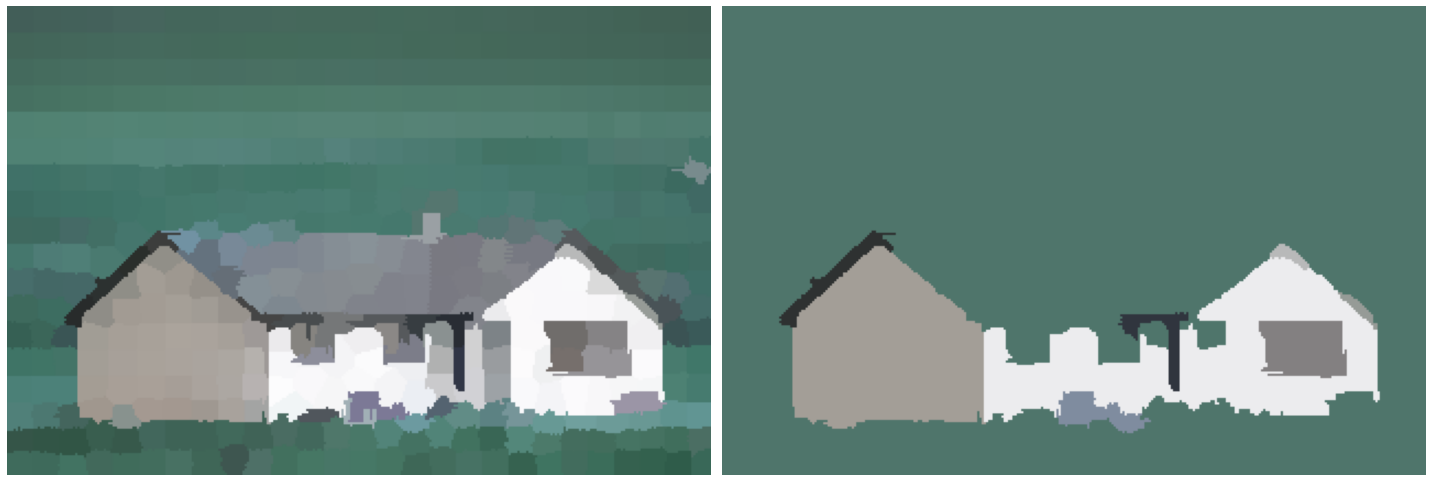

In [13]:
# segment a chosen image

from skimage import data, segmentation, color
from skimage.future import graph


img = test_imgs[idx]

labels1 = segmentation.slic(img, compactness=30, n_segments=500, # try to play with compactness
                            start_label=1)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

# iterate ncut to get less regions while trying to keep coherent the resulting regions
ncut_iter = 4
labels2 = labels1
for i in range(ncut_iter):
    g = graph.rag_mean_color(img, labels2, mode='similarity')
    labels2 = graph.cut_normalized(labels2, g)
    out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20,20))

ax[0].imshow(out1.astype('uint8'))
ax[1].imshow(out2.astype('uint8'))


for a in ax:
    a.axis('off')

plt.tight_layout()

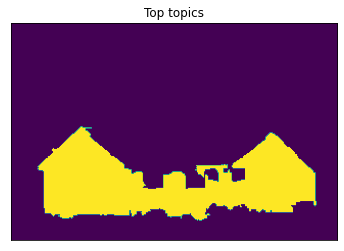

In [14]:
# topic segmentation based on coloring only top topics
# init regions topic perc (relevant topic - rest of topics)
labels = labels2
unique_labels, counts = np.unique(labels, return_counts=True)
prob_background = unique_labels[np.argmax(counts)] # we don't want to print this, too large

relevant_topics = document_top_topics
test_img_idx = idx
img_regions_topics = {}
for label in np.unique(labels):
    img_regions_topics[label] = [0, 0]
test_imgs_des_topic = []
for i in range(len(test_imgs_des[test_img_idx])):
    test_imgs_des_topic.append(des2topic(test_imgs_des[test_img_idx][i],kmeans_res, model=lda))

for i in range(len(test_imgs_des_topic)):
    kp_xy = test_imgs_kp[test_img_idx][i].pt
    kp_xy = (round(kp_xy[1]), round(kp_xy[0])) # x,y but since it will be given as row, column of matrix..
    if test_imgs_des_topic[i]  in relevant_topics:
        img_regions_topics[labels[kp_xy]][0] += 1
    img_regions_topics[labels[kp_xy]][1] += 1
    
# understand which labels we want to print, then print them
relevant_labels = []        
for k,v in img_regions_topics.items():
    normalize = v[1]
    normalize = math.inf if normalize == 0 else normalize
    v = [v[0] / normalize, v[1] / normalize]
    img_regions_topics[k] = v
    if v[0] > 0.2:
        relevant_labels.append(k)
        
region_label = 1
img_regions = np.zeros(labels.shape)
for r in range(len(labels)):
    for c in range(len(labels[0])):
        if labels[r][c] in relevant_labels and labels[r][c] != prob_background:
#             print(f"r:{r} - c:{c}")
            img_regions[r][c] = region_label
plt.xticks([])
plt.yticks([])
plt.title("Top topics")
plt.imshow(img_regions)

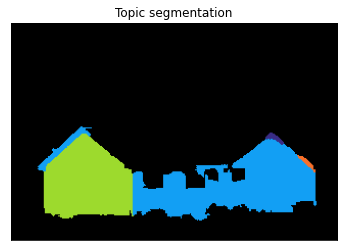

In [15]:
# topic segmentation over all regions
# create topic probability distribution for each region
test_img_idx = idx
img_regions_all_topics = {}
for label in np.unique(labels):
    img_regions_all_topics[label] = np.zeros(ntopic)
test_imgs_des_topic = []
for i in range(len(test_imgs_des[test_img_idx])):
    test_imgs_des_topic.append(des2topic(test_imgs_des[test_img_idx][i],kmeans_res, model=lda))

for i in range(len(test_imgs_des_topic)):
    kp_xy = test_imgs_kp[test_img_idx][i].pt
    kp_xy = (round(kp_xy[1]), round(kp_xy[0])) # x,y but since it will be given as row, column of matrix..
    img_regions_all_topics[labels[kp_xy]][test_imgs_des_topic[i]] += 1

# create colored img based on most probable topic of the region, plot it
img_regions = []
for r in range(len(labels)):
    img_regions_row = []
    for c in range(len(labels[0])):
        if labels[r][c] == prob_background:
            img_regions_row.append([0,0,0])
        else:
            img_regions_row.append(list(colors[np.argmax(img_regions_all_topics[labels[r][c]])]))
 
    img_regions.append(img_regions_row)
plt.xticks([])
plt.yticks([])
plt.title("Topic segmentation")
plt.imshow(img_regions)

# CLUSTERING USING DOC TOPIC DISTRIBUTION

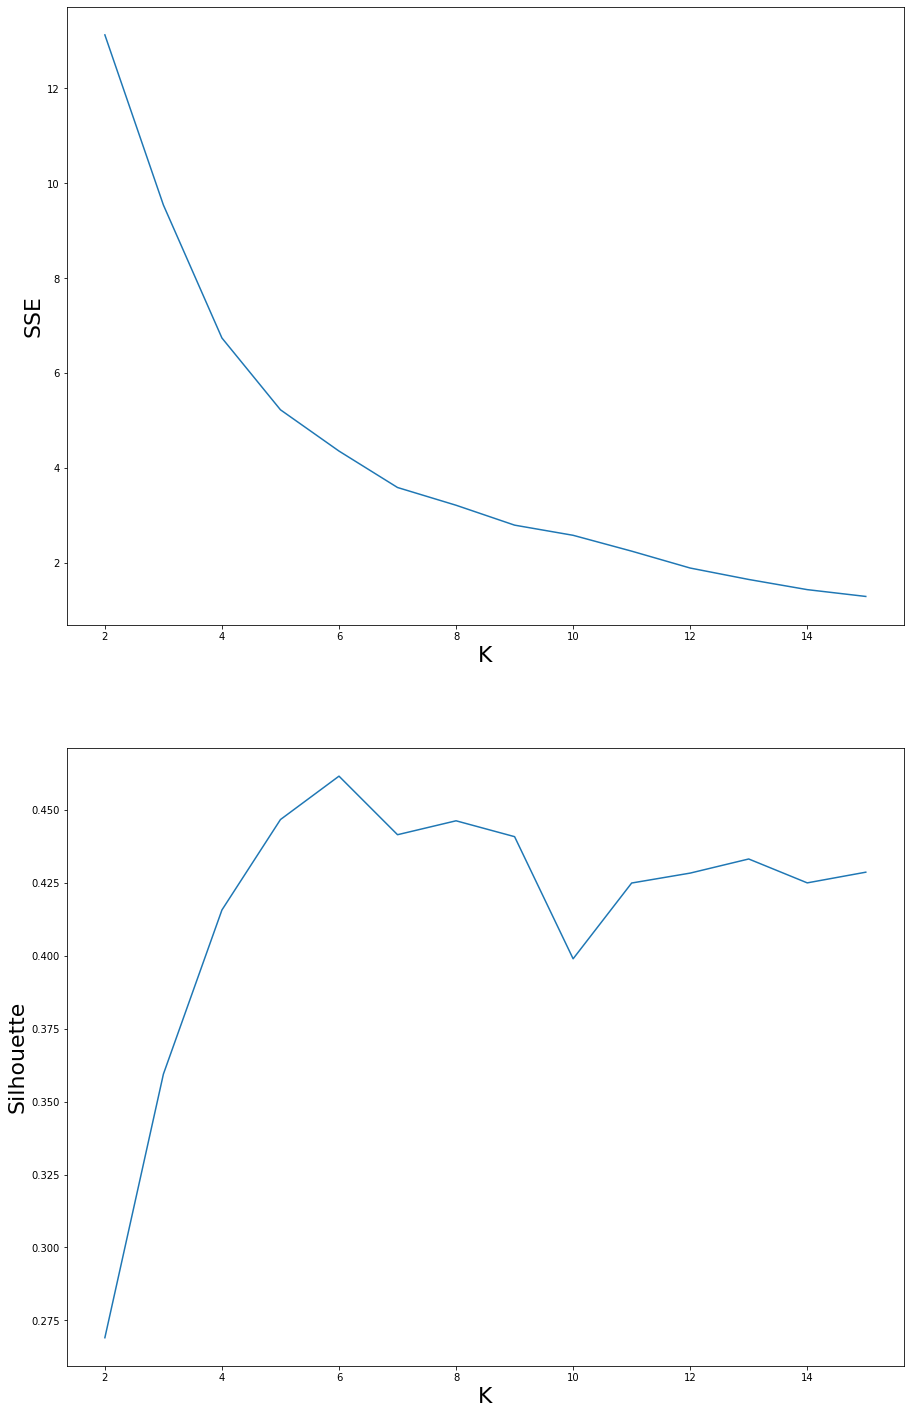

In [18]:
# construct topic percentages for test images
test_imgs_topic_perc = []
for i in range(len(test_bow)):
    test_imgs_topic_perc.append([el[1] for el in lda.get_document_topics(test_bow[i])])
test_imgs_topic_perc = np.array(test_imgs_topic_perc)

# run kmeans over topic space of test
sse_list = list()
sil_list = list()
max_k = 15
for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Iterating over possible K values"):
    kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans_iter.fit(test_imgs_topic_perc)
    
    sil_list.append(silhouette_score(test_imgs_topic_perc, kmeans_iter.labels_))
    sse = kmeans_iter.inertia_
    sse_list.append(sse)
# plot indicators
fig, axs = plt.subplots(2,1,figsize=(15,25))
axs[0].plot(range(2, len(sse_list) + 2), sse_list)
axs[0].set_ylabel('SSE', fontsize=22)
axs[0].set_xlabel('K', fontsize=22)
axs[0].tick_params(axis='both', which='major', labelsize=10)

axs[1].plot(range(2, len(sil_list) + 2), sil_list)
axs[1].set_ylabel('Silhouette', fontsize=22)
axs[1].set_xlabel('K', fontsize=22)
axs[1].tick_params(axis='both', which='major', labelsize=10)

In [19]:
# elbow rule for sse - highest silhouette possible
k = 6
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(test_imgs_topic_perc)
print("SSE:",sse_list[k-2]," - SILHOUETTE:",sil_list[k-2])

SSE: 4.356408596038818  - SILHOUETTE: 0.4615269


In [20]:
# divide the test set in the various clusters
test_clustered_files = {}
for i in range(len(kmeans.labels_)):
    label = kmeans.labels_[i]
    if label not in test_clustered_files:
        test_clustered_files[label] = [test_file_names[i]]
    else:
        test_clustered_files[label].append(test_file_names[i])
test_clustered_files

{5: ['3_12_s.bmp',
  '1_12_s.bmp',
  '3_11_s.bmp',
  '6_2_s.bmp',
  '5_13_s.bmp',
  '5_11_s.bmp',
  '6_8_s.bmp',
  '5_25_s.bmp',
  '6_6_s.bmp',
  '3_8_s.bmp'],
 4: ['7_29_s.bmp',
  '6_12_s.bmp',
  '7_10_s.bmp',
  '2_25_s.bmp',
  '3_14_s.bmp',
  '3_24_s.bmp',
  '6_21_s.bmp',
  '7_25_s.bmp',
  '1_4_s.bmp',
  '7_19_s.bmp',
  '7_21_s.bmp',
  '7_12_s.bmp'],
 2: ['4_20_s.bmp',
  '3_7_s.bmp',
  '4_23_s.bmp',
  '4_1_s.bmp',
  '4_25_s.bmp',
  '4_29_s.bmp'],
 3: ['7_6_s.bmp', '7_9_s.bmp'],
 0: ['5_2_s.bmp',
  '6_16_s.bmp',
  '2_5_s.bmp',
  '2_19_s.bmp',
  '8_4_s.bmp',
  '8_25_s.bmp',
  '2_21_s.bmp',
  '3_6_s.bmp',
  '1_24_s.bmp',
  '2_9_s.bmp',
  '8_26_s.bmp',
  '8_23_s.bmp',
  '2_29_s.bmp'],
 1: ['4_30_s.bmp', '1_6_s.bmp', '4_10_s.bmp', '1_3_s.bmp']}

### FINALLY PRINTING CLUSTER BY TOPIC (PLAY WITH THE topicnum NUMBER)

Cluster n.2 out of 6


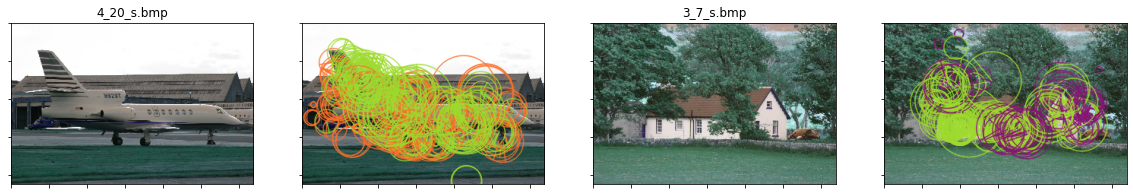

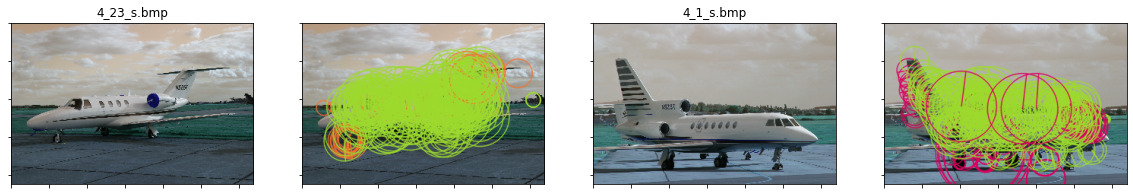

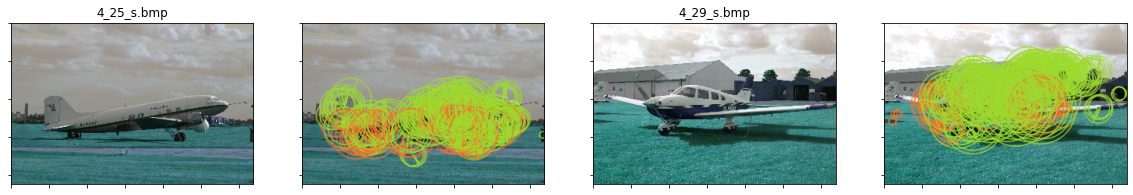

In [21]:
topicnum = 2
print(f"Cluster n.{topicnum} out of {kmeans.n_clusters}")
print_helper = 0
for i in range(len(test_clustered_files[topicnum])):
    if print_helper==0: fig,axs=plt.subplots(1,4, figsize=(20,20))
    img_idx = img_name2index(test_clustered_files[topicnum][i],test_file_names)
    print_this = test_imgs[img_idx]
    axs[print_helper].imshow(print_this)
    axs[print_helper].title.set_text(test_clustered_files[topicnum][i])
    lda_doc_top = lda.get_document_topics(test_bow[img_idx])
    document_top_topics = np.argsort(np.array([el[1] for el in lda.get_document_topics(test_bow[img_idx])]))[-2:]
    top_topic_kp = []
    kp_colors = []
    for i in range(len(test_imgs_des[img_idx])):
        kp_topic = des2topic(test_imgs_des[img_idx][i],kmeans_res,model=lda)
        if kp_topic in document_top_topics:
            top_topic_kp.append(test_imgs_kp[img_idx][i])
            kp_colors.append(colors[kp_topic])
    top_topic_kp = np.array(top_topic_kp)
#     print("Top topic:",document_top_topics)
    print_this = prediction(lda, test_imgs[img_idx], test_bow[img_idx],top_topic_kp,kp_colors, show=False)
    axs[print_helper + 1].imshow(print_this)
    if print_helper==2: 
        for j in range(4):
            axs[j].set_yticklabels([])
            axs[j].set_xticklabels([])
        plt.show()
    print_helper = 2 if print_helper == 0 else 0
    test_file_names[img_idx]